In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import keras
import keras.models as models
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import BatchNormalization, Input, add, concatenate
from keras.layers import TimeDistributed, LSTM
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import model_from_json, load_model
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from keras.callbacks import ModelCheckpoint
import cv2
import os
import csv
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
from keras.callbacks import CSVLogger

In [3]:
steering = (10,20)
minS = 15
maxS = 15.7

In [4]:
def load_images(path):
    # initialize loop variables
    numImages = 0
    inputs = []
    processDataPath = path + "ProcessData.csv"
    if not os.path.isfile(processDataPath):
        print('ProcessData.csv must be in folder %s' %path)
        return
    # read images in ProcessData.csv and append to input
    with open(processDataPath, 'rt') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            numImages = numImages+1
            if not os.path.isfile(path + (row[0].lower())):
                print('%s not found.' %(path+(row[0].lower())))
                return
            image=cv2.imread(path + (row[0].lower()))
            img = cv2.resize(image, (200, 66))
            img = img / 255.
            inputs.append(img)
    print("Total number of images: %d" %numImages)
    return inputs

In [5]:
def read_output_data(path):
    Y=[]
    A=[]
    # ensure path exists
    processDataPath = path+"ProcessData.csv"
    if not os.path.isfile(processDataPath):
        print('ProcessData.csv not found in %s.' %path)
        return
    # open ProcessData.csv and append steering values and speeds to Y and A
    with open(processDataPath, 'rt') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            output = []
            y = (float(row[1]) - steering[0]) / (steering[1] - steering[0])
            output.append(y)
            Y.append(output)
            output1 = []
            x = (float(row[2]) - minS) / (maxS - minS)
            output1.append(x)
            A.append(output1)
    # return list of steering values and speeds
    return A, Y

In [6]:
def loadData(path):
    X = load_images(path)
    A, Y = read_output_data(path)
    X = np.array(X)
    A = np.array(A)
    Y = np.array(Y)
    return X, A, Y

In [ ]:
def createModel():
    model = Sequential()
    input1 = Input(shape=(66,200,3), name='image')
    input2 = Input(shape=(1,), name='steer')
    steer_inp = BatchNormalization(epsilon=0.001, axis=-1, momentum=0.99)(input1)
    layer1 = Conv2D(24, (5, 5), padding="valid", strides=(2, 2), activation="relu")(steer_inp)
    layer2 = Conv2D(36, (5, 5), padding="valid", strides=(2, 2), activation="relu")(layer1)
    layer3 = Conv2D(48, (5, 5), padding="valid", strides=(2, 2), activation="relu")(layer2)
    layer4 = Conv2D(64, (3, 3), padding="valid", strides=(1, 1), activation="relu")(layer3)
    layer5 = Conv2D(64, (3, 3), padding="valid", strides=(1, 1), activation="relu")(layer4)
    layer6 = Flatten()(layer5)
    layer7 = Dense(1164, activation='relu')(layer6)
    layer8 = Dense(100, activation='relu')(layer7)
    layer9 = Dense(100, activation= 'relu')(input2)
    merged = add([layer8, layer9])
    layer10 = Dense(50, activation='relu')(merged)
    layer11 = Dense(50, activation='relu')(layer10)
    layer12 = Dense(10, activation='relu')(layer11)
    steer_out = Dense(1, activation='tanh')(layer12)
    speed_out = Dense(1, activation='tanh')(layer12)
    out = concatenate([steer_out, speed_out])
    model= Model(inputs=[input1,input2], outputs=steer_out)
    model.summary()
    return model

In [ ]:
history = CSVLogger('kerasloss.csv', append=True, separator=';')
def trainModel(model, X, A, Y):
    adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='mse', optimizer=adam)
    filePath = "weights.best.hdf5"
    checkpoint = ModelCheckpoint(filePath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint, history]
    model.fit([X, A], Y, epochs=500, batch_size=64, callbacks=callbacks_list, verbose=1)

In [7]:
path = '/content/drive/My Drive/Colab Notebooks/Test1/'
X, A, Y= loadData(path)
print(X.shape)
print(Y.shape)
print(A.shape)

Total number of images: 3000
(3000, 66, 200, 3)
(3000, 1)
(3000, 1)


In [ ]:
model = createModel()
trainModel(model, X, A, Y)

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 66, 200, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 66, 200, 3)   12          image[0][0]                      
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 31, 98, 24)   1824        batch_normalization_5[0][0]      
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 14, 47, 36)   21636       conv2d_25[0][0]                  
______________________________________________________________________________________

In [ ]:
testPath = '/content/drive/My Drive/Colab Notebooks/DeepNNCar_Train1/'
Xtest, Atest, Ytest = loadData(testPath)

Total number of images: 1076


In [ ]:
from keras.models import load_model
print(Xtest.shape)
print(Ytest.shape)
print(Atest.shape)
saved_model = load_model("weights.best.hdf5")
outputs = saved_model.predict([Xtest, Atest], batch_size=1)

(1076, 66, 200, 3)
(1076, 1)
(1076, 1)


In [ ]:
mse = metrics.mean_squared_error(outputs, Ytest)
print(mse)

0.02605306818243969


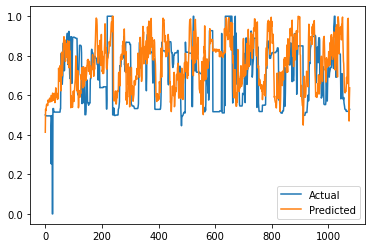

In [ ]:
plt.plot(Ytest)
plt.plot(outputs)
plt.legend(['Actual', 'Predicted'])